# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t60.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.358093  103.869308  108.378343  112.883076  \
0               30         10     6743.0      7525.0      7902.0      7515.0   
1               31         10     6867.0      7522.0      7727.0      7552.0   
2               32         10     6795.0      7669.0      8008.0      7693.0   
3               33         10     6848.0      7864.0      8034.0      7616.0   
4               34         10     6953.0      7902.0      8122.0      7688.0   
..             ...        ...        ...         ...         ...         ...   
85             555         18     8441.0      9862.0     10041.0      9731.0   
86             556         18     8482.0      9162.0      9671.0      9157.0   
87             557         18     8390.0      9146.0      9640.0      9539.0   
88             558         18     7959.0      9099.0      9462.0      8994.0   
89             559         18     8073.0      9538.0      9475.0      9041.0   

    117.385634  121.886020  126.382113  130.873918  ...  2470.019140  \
0       6888.0      6328.0      5620.0      5133.0  ...         56.0   
1       6892.0      6280.0      5701.0      5322.0  ...        131.0   
2       6802.0      6193.0      5786.0      5405.0  ...        110.0   
3       7081.0      6524.0      5877.0      5433.0  ...         82.0   
4       7021.0      6575.0      5973.0      5480.0  ...        107.0   
..         ...         ...         ...         ...  ...          ...   
85      8934.0      8426.0      7523.0      7124.0  ...        157.0   
86      8533.0      7955.0      7194.0      6868.0  ...        228.0   
87      8556.0      8049.0      7115.0      6956.0  ...        179.0   
88      8271.0      7782.0      6985.0      6494.0  ...        145.0   
89      8175.0      7759.0      7287.0      6722.0  ...        174.0   

    2473.183625  2476.346881  2479.507290  2482.668093  2485.827668  \
0         128.0         55.0        185.0        118.0        146.0   
1          71.0         83.0        113.0        103.0         86.0   
2         133.0         93.0        156.0        122.0         84.0   
3         125.0         45.0        114.0         56.0        125.0   
4         117.0         72.0        116.0        115.0        100.0   
..          ...          ...          ...          ...          ...   
85        216.0        129.0        216.0        113.0        190.0   
86        192.0        156.0        210.0        179.0        194.0   
87        182.0        104.0        149.0        139.0        166.0   
88        197.0        203.0        177.0        186.0        241.0   
89        190.0        160.0        244.0        144.0        137.0   

    2488.984401  2492.141526  2495.295811  2498.445642  
0          60.0        112.0        119.0        119.0  
1          86.0        144.0         87.0        104.0  
2          82.0         74.0        130.0        140.0  
3          77.0        149.0         80.0        100.0  
4          95.0        101.0        141.0         78.0  
..          ...          ...          ...          ...  
85        114.0        240.0        125.0        184.0  
86        133.0        168.0        192.0        218.0  
87        165.0        154.0        145.0        148.0  
88        120.0        200.0        180.0        196.0  
89        145.0        166.0        138.0        200.0  

[90 rows x 638 columns]

# Test Plots and Baseline Correction

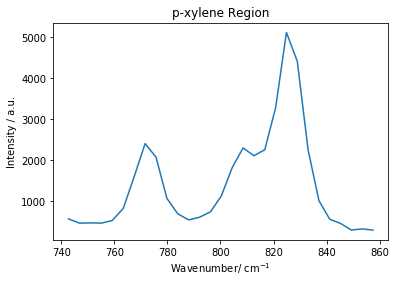

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

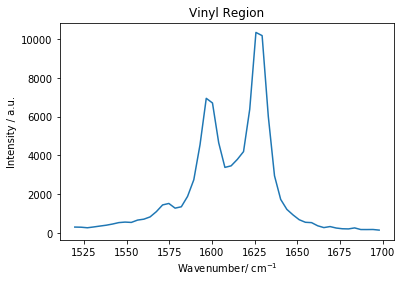

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

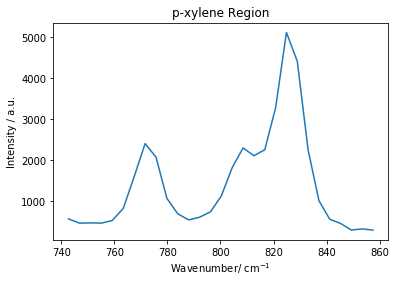

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.72591, 561.0),
 (746.854286, 457.0),
 (750.982753, 463.0),
 (755.109328, 457.0),
 (759.232034, 523.0),
 (845.269156, 450.0),
 (849.338942, 289.0),
 (853.40688, 316.0),
 (857.472972, 287.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

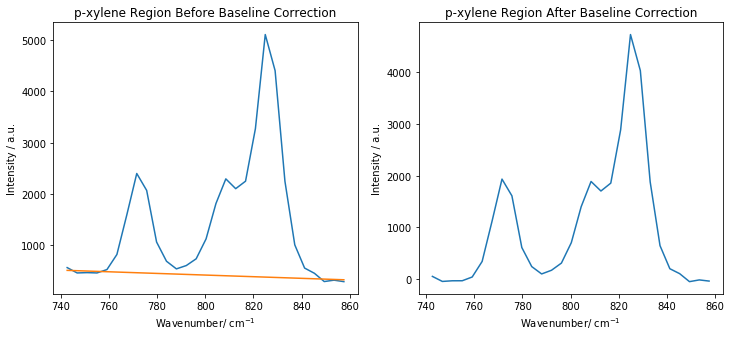

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

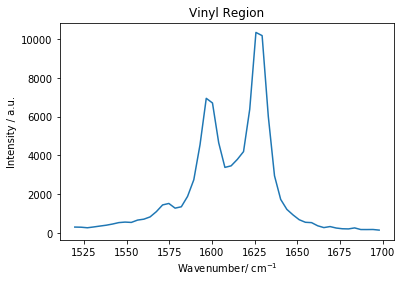

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.646641, 308.0),
 (1523.334285, 301.0),
 (1527.018539, 272.0),
 (1530.701218, 314.0),
 (1534.382324, 360.0),
 (1538.060047, 404.0),
 (1541.738012, 464.0),
 (1545.412596, 538.0),
 (1549.083803, 565.0),
 (1552.755255, 548.0),
 (1665.520301, 281.0),
 (1669.126213, 334.0),
 (1672.72882, 259.0),
 (1676.331694, 221.0),
 (1679.929484, 213.0),
 (1683.527541, 265.0),
 (1687.122303, 181.0),
 (1690.715552, 180.0),
 (1694.30729, 183.0),
 (1697.897518, 151.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

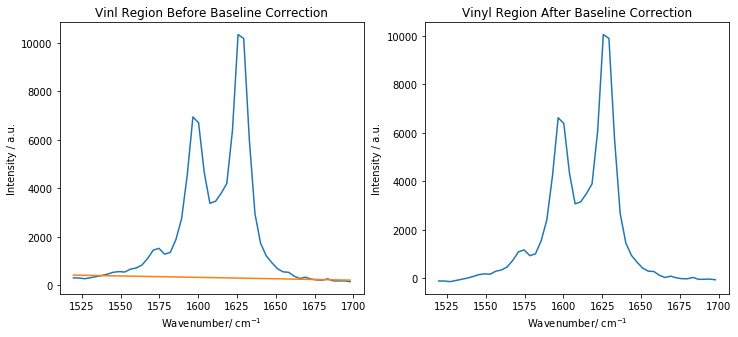

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.646641  1523.334285  1527.018539  1530.701218  1534.382324  \
0         308.0        301.0        272.0        314.0        360.0   
1         287.0        349.0        239.0        323.0        327.0   
2         318.0        284.0        338.0        336.0        386.0   
3         283.0        329.0        286.0        283.0        354.0   
4         297.0        306.0        321.0        324.0        363.0   
..          ...          ...          ...          ...          ...   
85        370.0        420.0        422.0        470.0        502.0   
86        408.0        429.0        430.0        433.0        568.0   
87        295.0        392.0        356.0        497.0        524.0   
88        388.0        450.0        420.0        478.0        552.0   
89        405.0        419.0        432.0        432.0        525.0   

    1538.060047  1541.738012  1545.412596  1549.083803  1552.755255  ...  \
0         404.0        464.0        538.0        565.0        548.0  ...   
1         468.0        435.0        492.0        650.0        536.0  ...   
2         486.0        469.0        492.0        555.0        540.0  ...   
3         398.0        461.0        477.0        572.0        565.0  ...   
4         409.0        477.0        481.0        606.0        554.0  ...   
..          ...          ...          ...          ...          ...  ...   
85        621.0        662.0        665.0        873.0        805.0  ...   
86        618.0        693.0        709.0        835.0        748.0  ...   
87        648.0        664.0        730.0        756.0        756.0  ...   
88        621.0        616.0        721.0        770.0        765.0  ...   
89        495.0        687.0        714.0        804.0        787.0  ...   

    1665.520301  1669.126213  1672.728820  1676.331694  1679.929484  \
0         281.0        334.0        259.0        221.0        213.0   
1         339.0        331.0        318.0        260.0        246.0   
2         302.0        339.0        303.0        217.0        237.0   
3         287.0        316.0        277.0        282.0        223.0   
4         318.0        285.0        335.0        194.0        222.0   
..          ...          ...          ...          ...          ...   
85        496.0        473.0        446.0        458.0        366.0   
86        616.0        530.0        406.0        432.0        376.0   
87        479.0        429.0        411.0        357.0        328.0   
88        484.0        498.0        494.0        390.0        376.0   
89        500.0        507.0        492.0        413.0        353.0   

    1683.527541  1687.122303  1690.715552  1694.307290  1697.897518  
0         265.0        181.0        180.0        183.0        151.0  
1         298.0        198.0        214.0        189.0        254.0  
2         284.0        243.0        225.0        190.0        172.0  
3         240.0        187.0        181.0        166.0        236.0  
4         230.0        171.0        145.0        208.0        140.0  
..          ...          ...          ...          ...          ...  
85        334.0        341.0        353.0        316.0        293.0  
86        338.0        348.0        346.0        341.0        325.0  
87        356.0        303.0        330.0        273.0        299.0  
88        381.0        367.0        242.0        349.0        277.0  
89        362.0        338.0        319.0        301.0        339.0  

[90 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 140000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 180000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 5

## Fitting and Plotting (Vinyl Region)

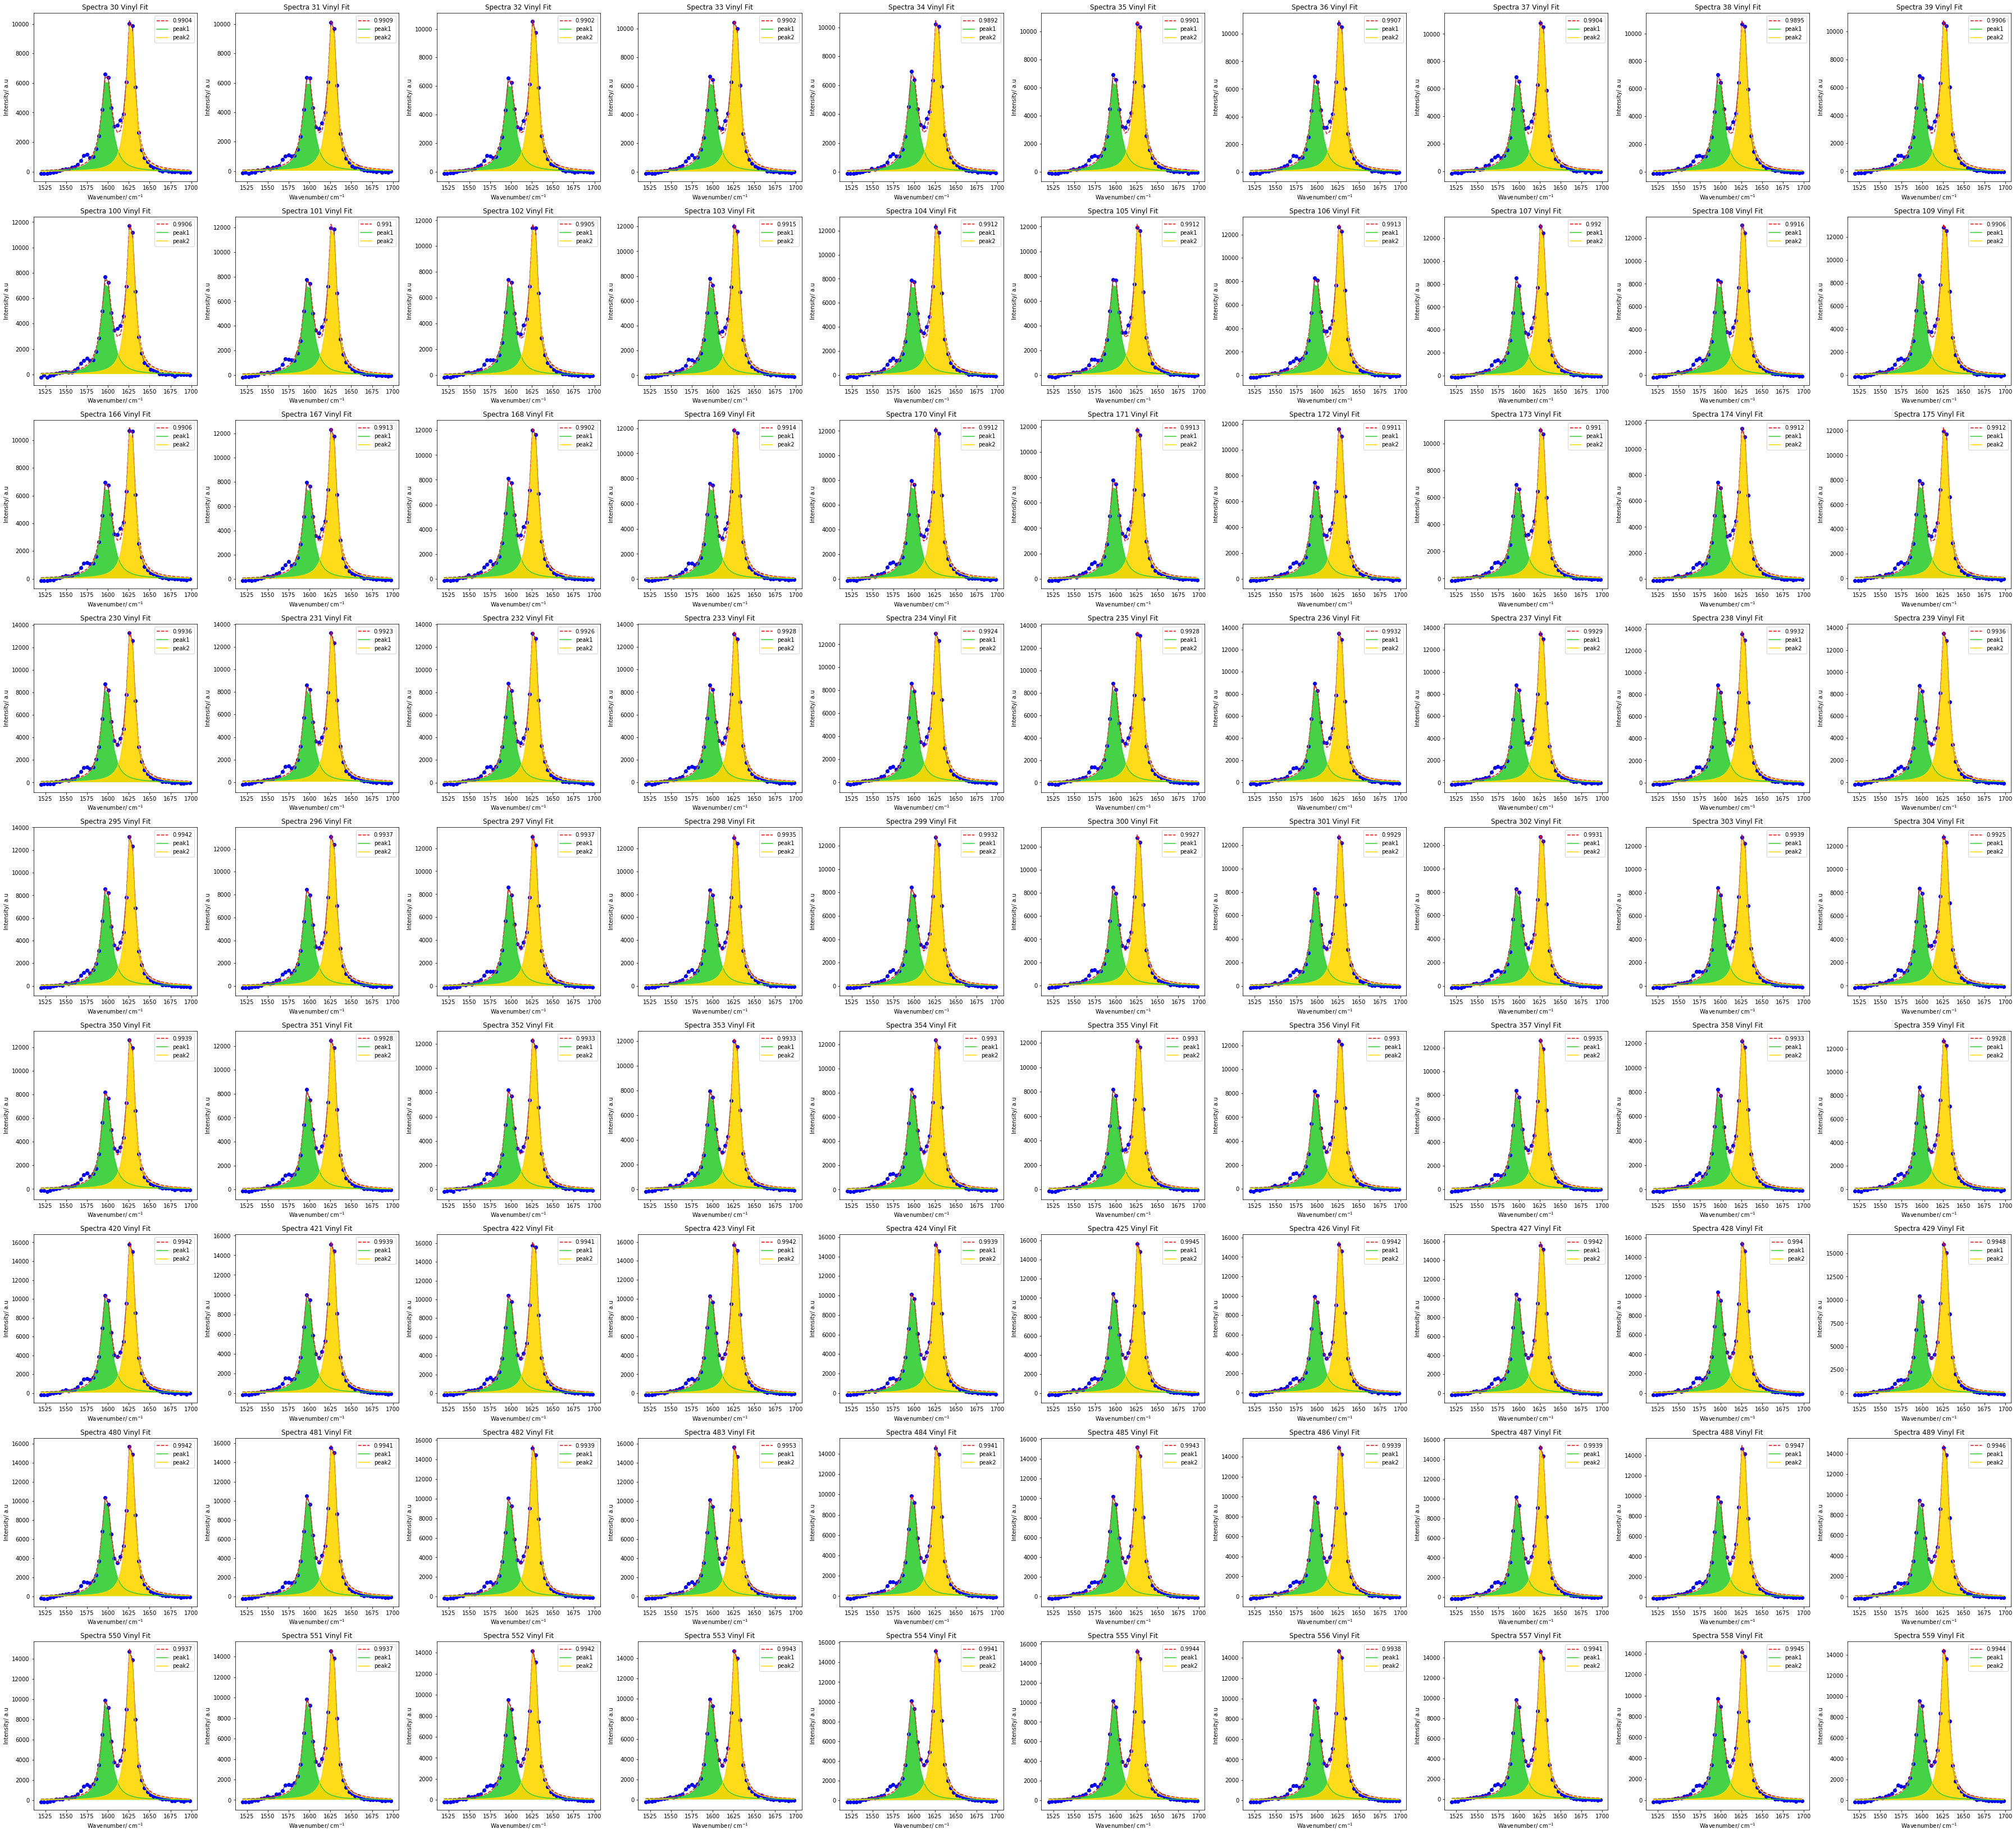

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2      widL1  \
count      90.000000      90.000000    90.000000    90.000000  90.000000   
mean   178935.224937  232459.058869  1598.110977  1627.286757   6.728843   
std     18501.581336   25711.182725     0.170284     0.044917   0.297565   
min    140656.788655  184016.559723  1597.866013  1627.169006   6.249399   
25%    168132.639353  215699.209581  1597.967681  1627.260460   6.481940   
50%    176833.791172  229065.936013  1598.057309  1627.281370   6.664830   
75%    195558.824852  255282.636710  1598.288602  1627.310703   6.974114   
max    212190.117929  279153.195532  1598.456487  1627.412899   7.404690   

           widL2   R2_Vinyl    FWHM_L1    FWHM_L2     Height_L1     Height_L2  
count  90.000000  90.000000  90.000000  90.000000     90.000000     90.000000  
mean    5.301651   0.992722  13.457687  10.603301   8512.225209  13989.105660  
std     0.120023   0.001509   0.595131   0.240047   1197.724410   1786.811448  
min     5.073174   0.989209  12.498798  10.146349   6287.786246  10633.244248  
25%     5.218488   0.991251  12.963880  10.436977   7781.190906  12809.004709  
50%     5.288841   0.993159  13.329659  10.577682   8314.277440  13711.181758  
75%     5.374830   0.993977  13.948228  10.749661   9760.257417  15636.470809  
max     5.644061   0.995332  14.809380  11.288122  10402.792889  17196.971156

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0               30         10    177177.091163  0.990364
1               31         10    176435.398167  0.990854
2               32         10    178711.795923  0.990181
3               33         10    183451.700327  0.990196
4               34         10    183542.142932  0.989209
..             ...        ...              ...       ...
85             555         18    252820.653874  0.994409
86             556         18    246107.076574  0.993777
87             557         18    244786.306601  0.994142
88             558         18    238925.475017  0.994541
89             559         18    236434.084240  0.994443

[90 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.725910  746.854286  750.982753  755.109328  759.232034  763.352854  \
0        561.0       457.0       463.0       457.0       523.0       817.0   
1        563.0       452.0       393.0       479.0       533.0       850.0   
2        548.0       488.0       416.0       438.0       604.0       820.0   
3        572.0       452.0       451.0       439.0       525.0       799.0   
4        581.0       450.0       400.0       433.0       585.0       855.0   
..         ...         ...         ...         ...         ...         ...   
85       805.0       626.0       726.0       764.0       999.0      1323.0   
86       775.0       672.0       756.0       696.0       882.0      1327.0   
87       730.0       631.0       670.0       692.0       935.0      1315.0   
88       699.0       624.0       684.0       722.0       947.0      1329.0   
89       829.0       669.0       730.0       753.0       934.0      1227.0   

    767.471788  771.586862  775.700054  779.811367  ...  820.793869  \
0       1591.0      2397.0      2067.0      1060.0  ...      3272.0   
1       1691.0      2477.0      2088.0      1053.0  ...      3324.0   
2       1612.0      2483.0      2012.0      1120.0  ...      3367.0   
3       1671.0      2464.0      2062.0      1078.0  ...      3402.0   
4       1754.0      2714.0      2075.0      1199.0  ...      3423.0   
..         ...         ...         ...         ...  ...         ...   
85      2495.0      3731.0      3134.0      1680.0  ...      2144.0   
86      2447.0      3603.0      3058.0      1674.0  ...      2011.0   
87      2338.0      3591.0      3018.0      1594.0  ...      1939.0   
88      2421.0      3567.0      2974.0      1583.0  ...      1922.0   
89      2331.0      3631.0      2977.0      1613.0  ...      1983.0   

    824.876741  828.959721  833.040843  837.120109  841.195559  845.269156  \
0       5108.0      4404.0      2245.0      1005.0       552.0       450.0   
1       4973.0      4387.0      2316.0      1083.0       541.0       359.0   
2       5215.0      4535.0      2388.0      1055.0       641.0       443.0   
3       5135.0      4466.0      2311.0      1061.0       569.0       439.0   
4       4877.0      4607.0      2407.0      1105.0       500.0       391.0   
..         ...         ...         ...         ...         ...         ...   
85      3054.0      2678.0      1655.0       974.0       722.0       538.0   
86      2896.0      2560.0      1425.0       940.0       688.0       547.0   
87      2923.0      2433.0      1595.0       949.0       736.0       492.0   
88      2848.0      2471.0      1461.0       940.0       672.0       576.0   
89      2724.0      2358.0      1386.0       901.0       702.0       542.0   

    849.338942  853.406880  857.472972  
0        289.0       316.0       287.0  
1        257.0       300.0       258.0  
2        355.0       327.0       211.0  
3        264.0       292.0       265.0  
4        319.0       310.0       271.0  
..         ...         ...         ...  
85       431.0       420.0       437.0  
86       419.0       407.0       360.0  
87       363.0       419.0       371.0  
88       403.0       470.0       427.0  
89       424.0       435.0       347.0  

[90 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

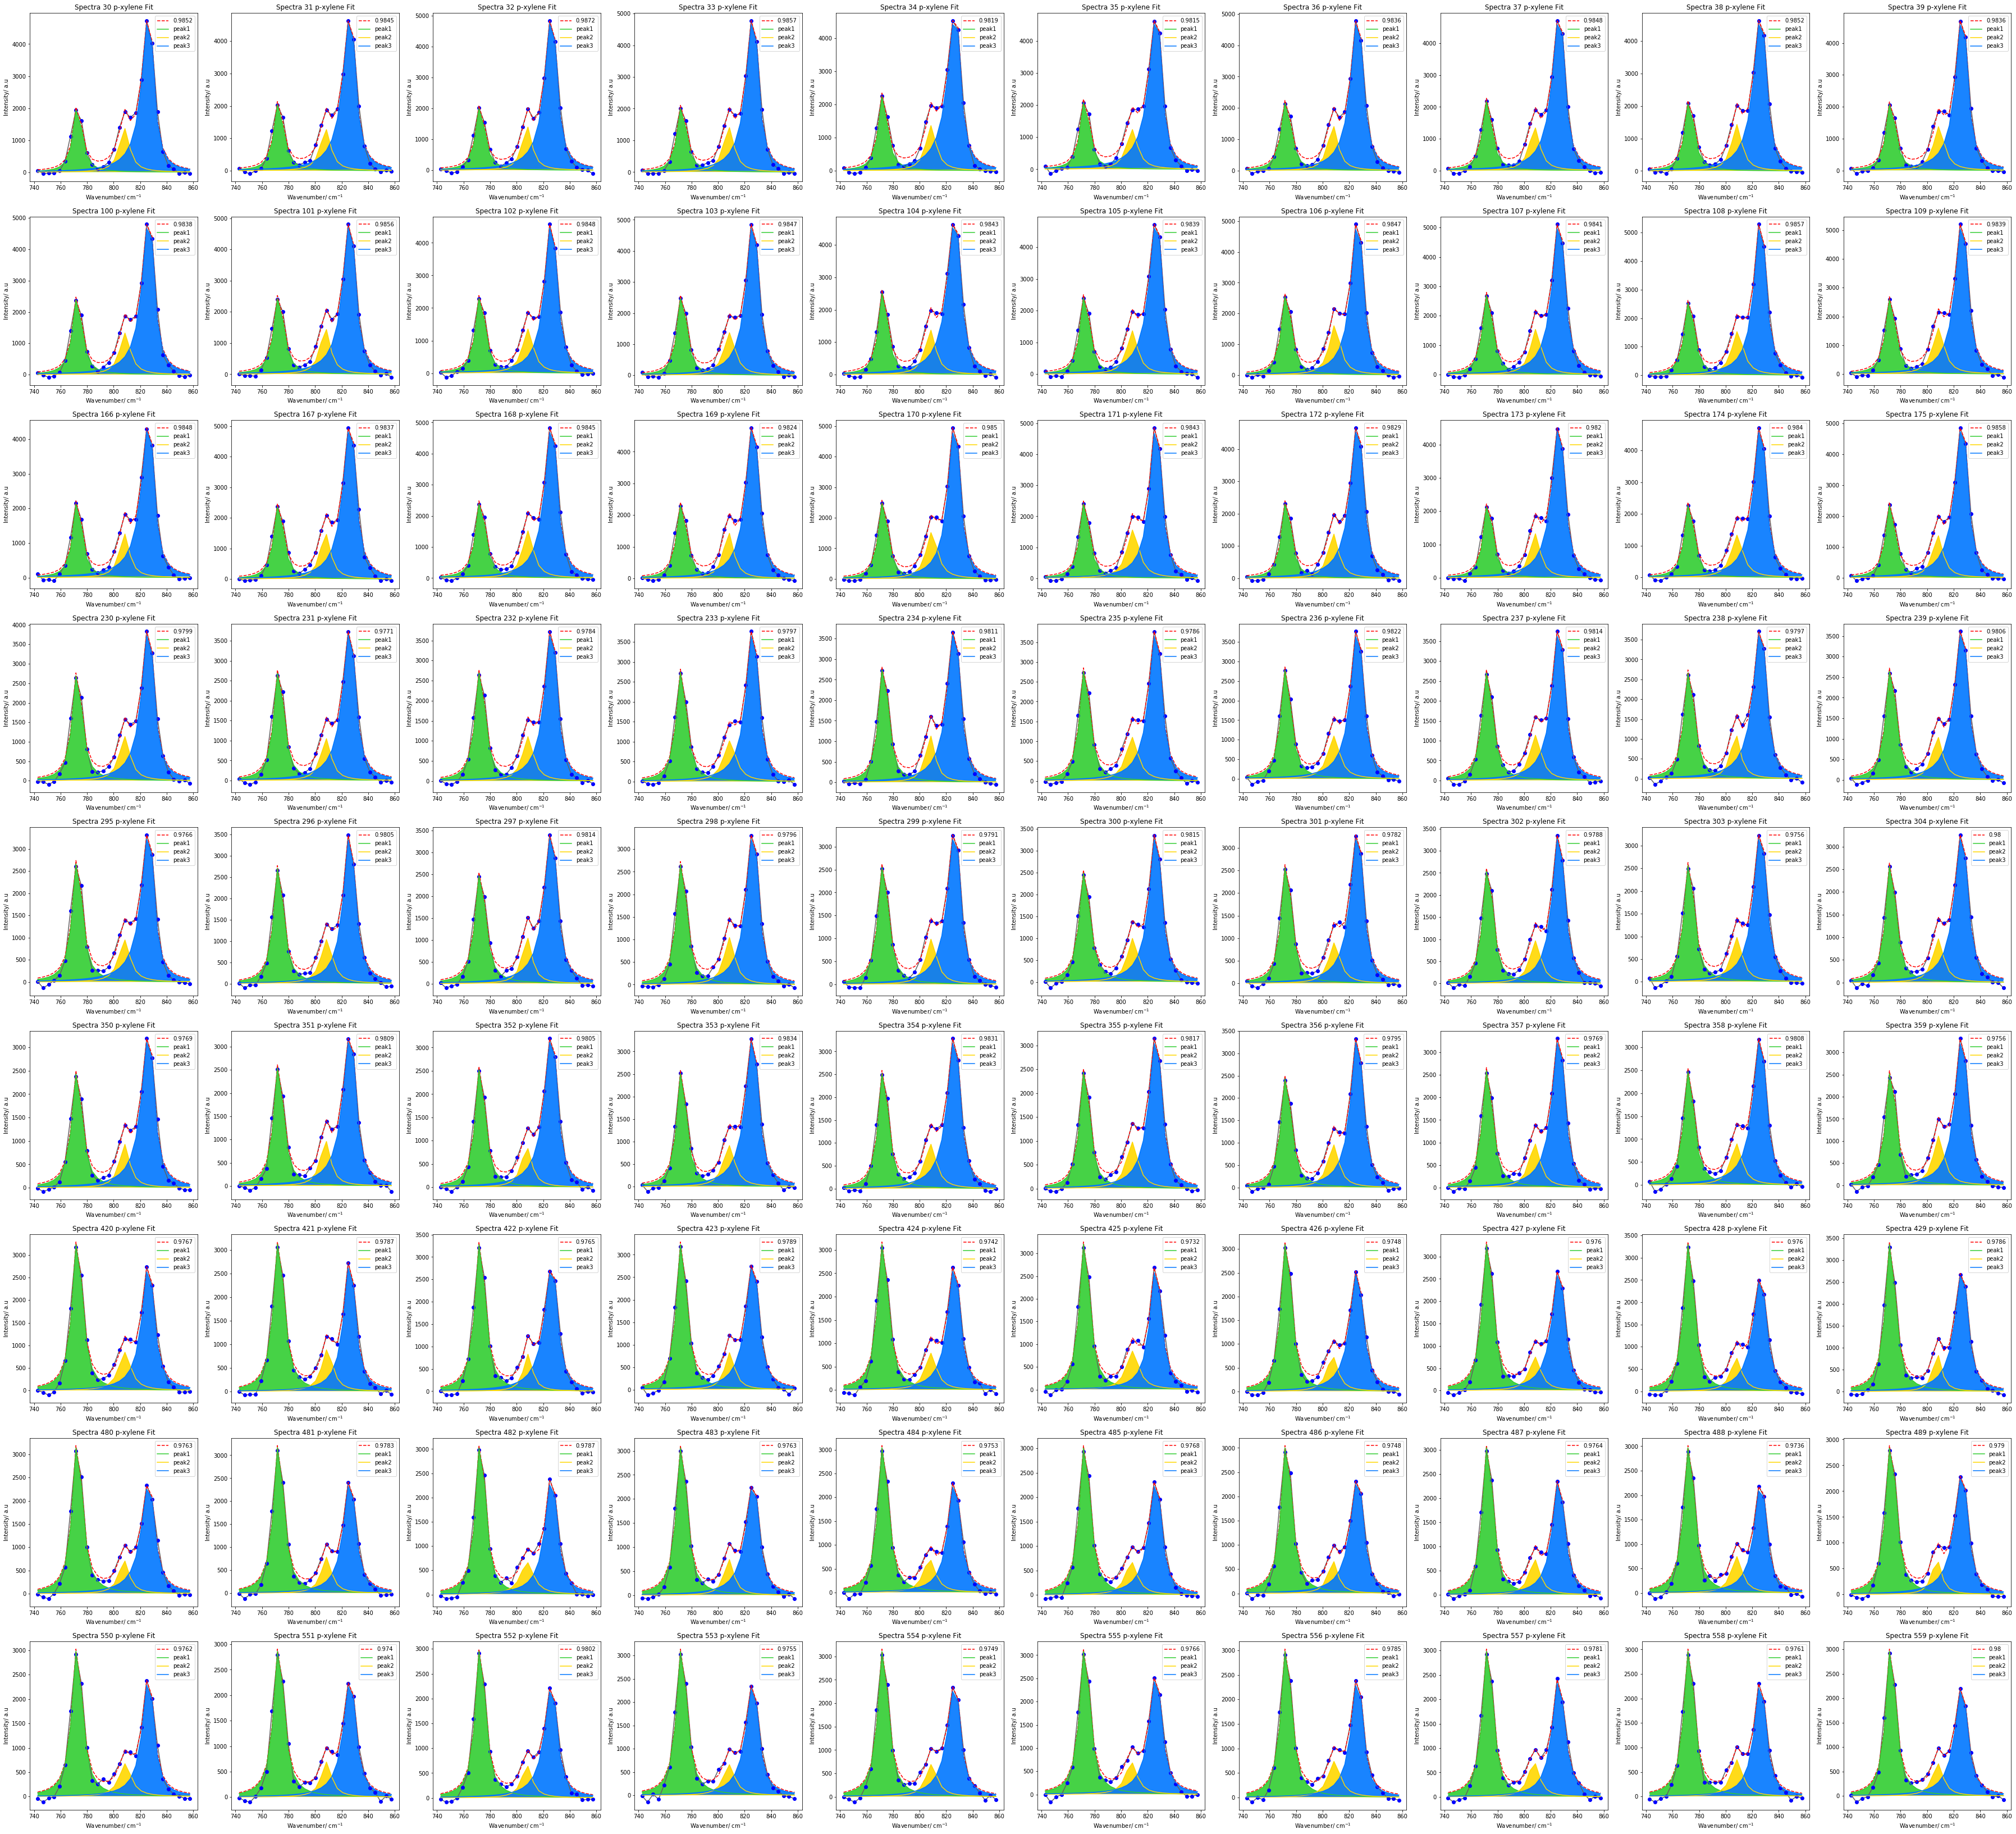

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2         ampL3       cenL1       cenL2  \
count     90.000000     90.000000     90.000000   90.000000   90.000000   
mean   38674.437877  16403.699285  65232.669745  772.627967  808.220411   
std     6580.958467   4519.907271  18423.138464    0.125919    0.435131   
min    26450.572706   9186.741866  38891.691859  772.311516  807.200870   
25%    33978.479582  12287.587600  47189.259258  772.558733  807.849780   
50%    37651.903868  15496.862493  60935.358396  772.633012  808.240224   
75%    45385.630566  20212.125778  86153.670433  772.717451  808.522450   
max    50293.384204  26737.934923  95133.990078  772.891542  809.137481   

            cenL3      widL1      widL2      widL3      widL4    R2_pxyl  \
count   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   826.827245   4.362487   4.947395   6.658324   4.450969   0.980177   
std      0.183931   0.218109   0.363841   0.391447   0.196579   0.003608   
min    826.293388   3.901945   4.010342   5.506916   4.123447   0.973206   
25%    826.714045   4.188883   4.704343   6.387474   4.319340   0.976826   
50%    826.839339   4.383521   4.964149   6.723363   4.432138   0.979975   
75%    826.943683   4.552257   5.193573   6.959458   4.539153   0.983704   
max    827.310898   4.756964   6.034694   7.479184   5.231006   0.987210   

         FWHM_L1    FWHM_L2    FWHM_L3    Height_L1    Height_L2    Height_L3  
count  90.000000  90.000000  90.000000    90.000000    90.000000    90.000000  
mean    8.724975   9.894790  11.109292  2808.233359  1058.534391  1871.726601  
std     0.436217   0.727682   0.400801   367.061315   292.246927   535.276960  
min     7.803890   8.020684  10.102811  2126.502185   655.211081  1133.818663  
25%     8.377765   9.408686  10.829868  2561.616991   784.310142  1377.749995  
50%     8.767042   9.928299  11.128327  2750.680737   990.115597  1746.069975  
75%     9.104515  10.387146  11.391781  3151.876151  1358.398853  2479.203571  
max     9.513929  12.069389  11.915562  3466.005499  1618.601349  2802.231546

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               30         10    177177.091163  0.990364    79220.582492   
1               31         10    176435.398167  0.990854    82331.291143   
2               32         10    178711.795923  0.990181    82848.538236   
3               33         10    183451.700327  0.990196    81785.980184   
4               34         10    183542.142932  0.989209    84166.285641   
..             ...        ...              ...       ...             ...   
85             555         18    252820.653874  0.994409    42541.139887   
86             556         18    246107.076574  0.993777    38488.938878   
87             557         18    244786.306601  0.994142    40117.940457   
88             558         18    238925.475017  0.994541    36409.598791   
89             559         18    236434.084240  0.994443    37818.427737   

     R2_pxyl  
0   0.985160  
1   0.984458  
2   0.987210  
3   0.985686  
4   0.981867  
..       ...  
85  0.976577  
86  0.978503  
87  0.978072  
88  0.976143  
89  0.979952  

[90 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               30         10    177177.091163  0.990364    79220.582492   
1               31         10    176435.398167  0.990854    82331.291143   
2               32         10    178711.795923  0.990181    82848.538236   
3               33         10    183451.700327  0.990196    81785.980184   
4               34         10    183542.142932  0.989209    84166.285641   
..             ...        ...              ...       ...             ...   
85             555         18    252820.653874  0.994409    42541.139887   
86             556         18    246107.076574  0.993777    38488.938878   
87             557         18    244786.306601  0.994142    40117.940457   
88             558         18    238925.475017  0.994541    36409.598791   
89             559         18    236434.084240  0.994443    37818.427737   

     R2_pxyl  Vinyl Divide pxyl  
0   0.985160           2.236503  
1   0.984458           2.142993  
2   0.987210           2.157091  
3   0.985686           2.243070  
4   0.981867           2.180709  
..       ...                ...  
85  0.976577           5.942968  
86  0.978503           6.394229  
87  0.978072           6.101667  
88  0.976143           6.562156  
89  0.979952           6.251822  

[90 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
10                     10.0  2.225985  0.057926  2.142993  2.185844  2.234117   
11                     10.0  2.546268  0.076492  2.464713  2.484592  2.531897   
12                     10.0  2.470561  0.081814  2.388663  2.399097  2.462049   
13                     10.0  3.536575  0.065316  3.452849  3.470866  3.545009   
14                     10.0  3.852193  0.088351  3.676534  3.818863  3.839327   
15                     10.0  3.743014  0.120599  3.530882  3.679354  3.724661   
16                     10.0  5.785208  0.293716  5.342383  5.662264  5.811972   
17                     10.0  6.386851  0.282318  5.872615  6.181919  6.439708   
18                     10.0  6.257026  0.216544  5.942968  6.107207  6.209745   

                               
                75%       max  
Condition                      
10         2.245808  2.331766  
11         2.581869  2.700412  
12         2.513585  2.630164  
13         3.583063  3.632764  
14         3.908250  3.979927  
15         3.796829  3.966114  
16         5.844172  6.403102  
17         6.582681  6.802834  
18         6.392424  6.581067

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(10,19)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         10    2.225985            0.057926
1         11    2.546268            0.076492
2         12    2.470561            0.081814
3         13    3.536575            0.065316
4         14    3.852193            0.088351
5         15    3.743014            0.120599
6         16    5.785208            0.293716
7         17    6.386851            0.282318
8         18    6.257026            0.216544

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201020 High Throughput Experiment Conditions 10 to 18\Online Raman\df_t60_ratio.csv')